# Generative Adversarial Networks con CIFAR10
A partir del conjunto de datos CIFAR10, se entrenará una *DCGAN* (*Deep Convolutional Generative Adversarial Network*) para generar nuevas imágenes. Una vez implementada la red, se agregará *experience replay* y compararemos los resultados con los obtenidos en la red inicial. Por último, convertiremos la red en una GAN condicional.


## Esquema del proyecto
El esquema del notebook será el siguiente:

1. Explicar qué es una *DCGAN* y cómo funciona (haciendo énfasis en explicar las dos partes principales de este tipo de modelos) 
1. Describir brevemente el conjunto de datos inicial (*CIFAR10*)
1. Entrenar una *DCGAN (Deep Convolutional Generative Adversarial Network)* para generar imágenes.
1. Añadir *experience replay*
1. Convertir la red a una *GAN condicional*

En primer lugar vamos a cargar las librerías y funciones de apoyo que se van a utilizar en el código del cuadernillo. Si se quiere utilizar alguna librería adicional se puede añadir dicha librería en este punto o en la celda de código en la que se vaya a utilizar por primera vez.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2022-06-12 15:41:05.619357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-12 15:41:05.619396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/bin/bash: line 1: nvidia-smi: command not found
GPUs Available:  0


2022-06-12 15:41:10.093979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-12 15:41:10.094022: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-12 15:41:10.094053: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JulioPC): /proc/driver/nvidia/version does not exist


## Consideraciones iniciales

Dado el tiempo de cómputo que exigen este tipo de redes se limitará el análisis de 50 epochs. Es muy recomendable, también que, si no se dispone de una tarjeta gráfica y una configuración compatible con tensorflow (puede comprobarse con la última salida del bloque anterior, si el número de GPUs disponible es 0) se utilice para la realización de esta práctica Google Colab. En este plataforma deberemos configurar el entorno de ejecución para que soporte GPUs, esto puede hacerse a través del menú *Entorno de ejecución* y la opción *Cambiar tipo de entorno de ejecución*, selecconando **GPU** como *Acelerador por hardware* .

In [2]:
# Definimos las constantes que utilizaremos a lo largo del cuadernillo
batch_size = 128
epochs = 50
latent_dim = 100

## Memoria

### ¿Qué es una DCGAN?
<mark>Antes de explicar qué es una DCGAN, explicaremos qué es una GAN. Una GAN o Generative Adversarial Network es un sistema compuesto por dos redes neuronales: Un generador, y un discriminador. En los sistemas GAN, el generador se encarga de intentar generar datos similares a los datos de entrada. El discriminador, por su parte, trata de intentar distinguir si los datos de entrada son reales, o generados por el generador. Durante cada iteración del entrenamiento de GANs, ocurren dos fases:
En la primera fase, se entrena el discriminador, a partir de un batch de una mezcla de datos reales y “fake” del generador, etiquetados, usando backpropagation.
En la segunda fase, se entrena el generador. Para entrenarlo, se produce otro batch de datos fake, y el discriminador intenta etiquetarlos correctamente, como fake o reales (aunque no haya reales en esta fase). Con el error obtenido y usando backpropagation, entrenamos el generador.
Por tanto, una Deep Convolutional GAN es una GAN basada en redes convolucionales, siendo las redes convolucionales redes con múltiples capas de filtros convolucionales de una o más dimensiones. Las DCGANs son una buena alternativa de aprendizaje no supervisado frente al aprendizaje supervisado con CNNs.</mark>


### CIFAR10
<mark>El dataset de CIFAR10 consiste en 60 mil imágenes a color de 32x32 píxeles, distribuidas entre 10 clases. Por defecto, viene la división train y test, donde 50 mil imágenes pertenecen al subset de train, y 10 mil al subset de test. Podemos encontrar una descripción más detallada en https://www.cs.toronto.edu/%7Ekriz/cifar.html</mark>

In [3]:
# En primer lugar vamos a descargar el conjunto de datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

In [4]:
# INICIO_RESPUESTA
# Requisitos: De como valor de la variable «semilla_aleatoria» los últimos dos dígitos de su documento de identificación
semilla_aleatoria = 54
# FIN_RESPUESTA

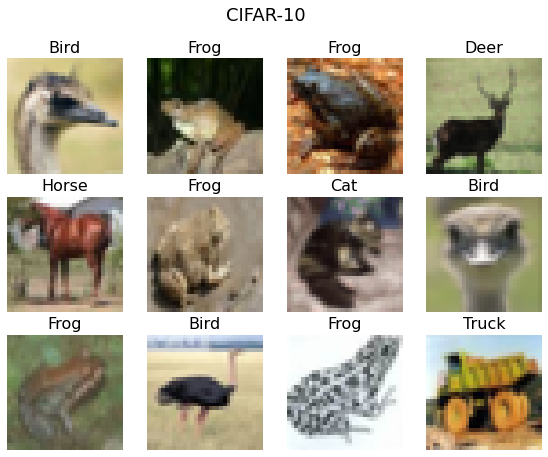

In [5]:
np.random.seed(semilla_aleatoria)
tf.random.set_seed(semilla_aleatoria)

# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

### Pre-procesado de datos
<mark>Ya que en la última capa del generador se utilizará la función de activación tangencial hiperbólica, la cual está acotada entre -1 y 1, como preprocesamiento de datos normalizaremos el dataset entre los valores \[-1, 1\].</mark>

In [6]:
# Dado que no tendremos una estructura de entrenamiento y validación, vamos a juntar todos las imágenes
all_imgs = np.concatenate([X_train, X_test])
all_labels = np.concatenate([Y_train, Y_test])

# INICIO_RESPUESTA
# Requisitos: Realice el pre-procesado de los datos de entrada teniendo en cuenta las recomendaciones que se indican en el capítulo 17 del libro, guarde el resultado en all_imgs.
all_imgs = np.float32(all_imgs / 255.0 * 2 - 1)
# FIN_RESPUESTA    

In [7]:
print(all_imgs.min())
print(all_imgs.mean())
print(all_imgs.max())

-1.0
-0.052200183
1.0


### DCGAN Inicial
En este apartado se quiere crear una primera red usando la API secuencial de Keras.  Es importante en este punto revisar las recomendaciones que se presentan en el capítulo 17 del libro:

<mark>

   *   Reemplazar las "pooling layers" con capas de convolución "strided" en el discriminador, y con convoluciones transpuestas en el generador.
   *   Usar normalización del batch tanto en el generador como en el discriminador, exceptuando la capa de output del generador e input del discriminador.
   *   Eliminar las capas ocultas totalmente conectadas en arquitecturas profundas
   *   Usar la función de activación ReLU para capas intermedias, y tanh para el output
   *   Usar leaky ReLU para todas las capas del discriminador</mark>



#### Generador

Para el generador se utilizará la siguiente estructura:

1. Capa densa y reshape a 8 x 8 x 128 
2. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa convolucional con 3 filtros (kernel de 3x3, 1 stride, padding 'same' y función de activación 'tanh')



In [8]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=(100,)),  

# INICIO_RESPUESTA
# Requisitos: Añada las capas indicadas para el generador      
    keras.layers.Dense(8*8*128),
    keras.layers.Reshape([8, 8, 128]),
    keras.layers.BatchNormalization(), # Recomendación del capítulo 17 del libro
    keras.layers.Conv2DTranspose(64, kernel_size=[4,4], strides=2, padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(64, kernel_size=[4,4], strides=2, padding="SAME", activation="relu"),
    keras.layers.Conv2D(3, kernel_size=[3,3], strides=1, padding="SAME", activation="tanh")
# FIN_RESPUESTA 
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       131136    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       65600     
 ranspose)                                                       
                                                        

2022-06-12 15:41:12.782726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Discriminador

Para el Discriminador se utilizará la siguiente estructura:

1. Capa convolucional con 32 filtros (kernel de 4x4, 2 strides y padding 'same')
2. Capa convolucional con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa convolucioanl con 128 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa Densa con función de activación sigmoide

Todas las capas convolucionales tienen una función de activación Leaky ReLU y, posteriormente se aplicarán normalización (BatchNormalization) y Dropout. Salvo la última capa convolucional que no aplicará normalización si no que aplanará el resultado de cara a la última capa densa.

In [9]:
discriminator = keras.models.Sequential([
# INICIO_RESPUESTA
# Requisitos: Añada las capas indicadas para el discriminador
    keras.layers.Conv2D(32, kernel_size=[4,4], strides=2, padding="SAME", activation=keras.layers.LeakyReLU(), input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(), # Recomendación del capítulo 17 del libro
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, kernel_size=[4,4], strides=2, padding="SAME", activation=keras.layers.LeakyReLU()),
    keras.layers.BatchNormalization(), # Recomendación del capítulo 17 del libro
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, kernel_size=[4,4], strides=2, padding="SAME", activation=keras.layers.LeakyReLU()),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
# FIN_RESPUESTA 
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        1568      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)         

#### Modelo
<mark>Durante el entrenamiento, el generdador y descriminador tienen objetivos opuestos. El discriminador trata de distinguir datos (suelen ser imágenes) fake de reales. En cambio, el discriminador trata de producir datos que parezcan tan reales que el discriminador falle al distinguirlos. Ya que hay dos redes neuronales a entrenar, cada step del entrenamiento consta de dos fases.

En cada step del entrenamiento, se toma un batch de imágenes reales. Además, usando el generador, obtenemos un batch de igual tamaño de imágenes falsas, generadas automáticamente. Una vez tenemos las imágenes falsas y reales, las combinamos, así como sus etiquetas. Con este set de imágenes, predecimos si son fake o no con uso del discriminador. Con estas etiquetas obtenidas, y a través de la función de pérdida de entropía cruzada binaria, entrenaremos los pesos del discriminador, sin tocar los del generador. Es decir, entrenamos el discriminador en función de su rendimiento distinguiento imágenes fake de reales.

Entramos en la fase de entrenar el generador. Esta vez, se engaña al discriminador: Volvemos a usarlo para predecir el batch anterior, pero con una diferencia, todas las imágenes están marcadas como reales. De esta forma, según los valores de pérdida que obtengamos, sabremos si el generador ha cumplido mejor o peor su función, la de engañar al discriminador. Con estos valores entrenamos los pesos del generador.

De esta forma, iterativamente vamos haciendo una lucha donde el discriminador trata de distinguir correctamente entre real y falso y el generador trata constantemente de engañar al discriminador. La idea pues, es que ambos vayan empujando al adversario a mejorar, haciéndose cada vez mejores, gracias al adversario.</mark>

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, show_range=10, enable_show=True, enable_save=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images += 1
          generated_images /= 2

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [11]:
def plt_loss(history): 
    '''
    Función que nos ayudará a visualizar la evolución de las pérdidas del generador y del discriminador
    '''
    f_num = "{:.3f}"
    plt.figure(figsize=(12,5))
    plt.suptitle("Función de pérdida", size=18)
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'])
    plt.title("Discriminador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'])
    plt.title("Generador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout(pad=4)
    plt.show()
    print(f"Pérdida discriminador: Min ({f_num.format(np.min(history.history['d_loss']))}) Max ({f_num.format(np.max(history.history['d_loss']))}) Media ({f_num.format(np.mean(history.history['d_loss']))})")
    print(f"Pérdida generador: Min ({f_num.format(np.min(history.history['g_loss']))}) Max ({f_num.format(np.max(history.history['g_loss']))}) Media ({f_num.format(np.mean(history.history['g_loss']))})")

#### Optimizadores y función de pérdida

In [12]:
# INICIO_RESPUESTA
# Requisitos: Inicialice los optimizadores que se utilizarán para el discriminador y para el generador
d_optimizer = keras.optimizers.RMSprop(0.002)
g_optimizer = keras.optimizers.RMSprop(0.002)
# FIN_RESPUESTA 

loss_fn = keras.losses.BinaryCrossentropy()

2022-06-12 15:41:13.440085: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 737280000 exceeds 10% of free system memory.
2022-06-12 15:41:13.683253: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/50
468/468 [==============================] - ETA: 0s - d_loss: 0.6997 - g_loss: 0.8134

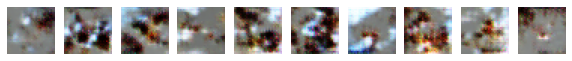

468/468 [==============================] - 185s 390ms/step - d_loss: 0.6997 - g_loss: 0.8134
Epoch 2/50
468/468 [==============================] - 180s 385ms/step - d_loss: 0.6935 - g_loss: 0.7497
Epoch 3/50
468/468 [==============================] - 181s 387ms/step - d_loss: 0.6937 - g_loss: 0.7537
Epoch 4/50
468/468 [==============================] - 181s 387ms/step - d_loss: 0.6923 - g_loss: 0.7455
Epoch 5/50
468/468 [==============================] - 181s 387ms/step - d_loss: 0.6921 - g_loss: 0.7451
Epoch 6/50
468/468 [==============================] - 181s 386ms/step - d_loss: 0.6920 - g_loss: 0.7447
Epoch 7/50
468/468 [==============================] - 182s 388ms/step - d_loss: 0.6920 - g_loss: 0.7447
Epoch 8/50
468/468 [==============================] - 179s 382ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 9/50
468/468 [==============================] - 179s 382ms/step - d_loss: 0.6919 - g_loss: 0.7447
Epoch 10/50
468/468 [==============================] - ETA: 0s - d_loss: 0.

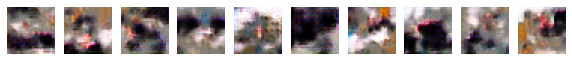

468/468 [==============================] - 179s 383ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 11/50
468/468 [==============================] - 179s 381ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 12/50
468/468 [==============================] - 179s 382ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 13/50
468/468 [==============================] - 179s 382ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 14/50
468/468 [==============================] - 179s 382ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 15/50
468/468 [==============================] - 179s 383ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 16/50
468/468 [==============================] - 179s 383ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 17/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 18/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 19/50
468/468 [==============================] - 177s 378ms/s

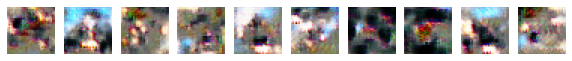

468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 21/50
468/468 [==============================] - 176s 376ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 22/50
468/468 [==============================] - 177s 377ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 23/50
468/468 [==============================] - 181s 386ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 24/50
468/468 [==============================] - 179s 383ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 25/50
468/468 [==============================] - 180s 385ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 26/50
468/468 [==============================] - 180s 384ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 27/50
468/468 [==============================] - 180s 384ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 28/50
468/468 [==============================] - 180s 384ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 29/50
468/468 [==============================] - 180s 385ms/s

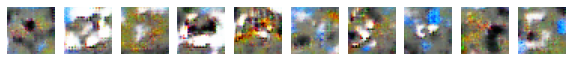

468/468 [==============================] - 180s 385ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 31/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 32/50
468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 33/50
468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 34/50
468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 35/50
468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 36/50
468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 37/50
468/468 [==============================] - 177s 377ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 38/50
468/468 [==============================] - 177s 379ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 39/50
468/468 [==============================] - 177s 379ms/s

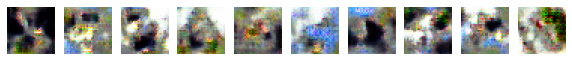

468/468 [==============================] - 177s 377ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 41/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 42/50
468/468 [==============================] - 177s 377ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 43/50
468/468 [==============================] - 177s 377ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 44/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 45/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 46/50
468/468 [==============================] - 176s 377ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 47/50
468/468 [==============================] - 177s 378ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 48/50
468/468 [==============================] - 177s 377ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 49/50
468/468 [==============================] - 176s 377ms/s

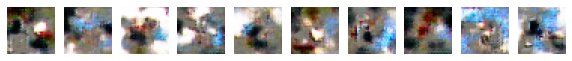

468/468 [==============================] - 176s 376ms/step - d_loss: 0.6919 - g_loss: 0.7445


In [13]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

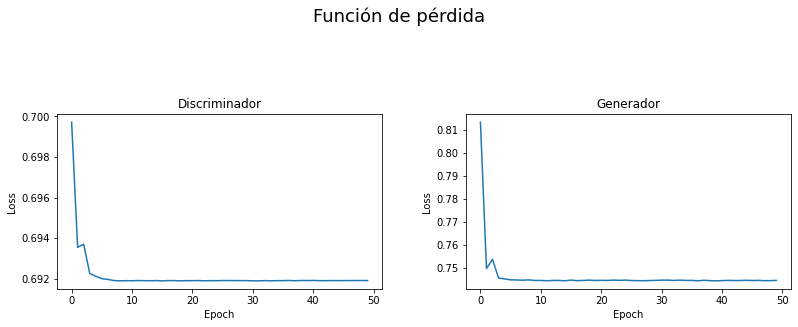

Pérdida discriminador: Min (0.692) Max (0.700) Media (0.692)
Pérdida generador: Min (0.744) Max (0.813) Media (0.746)


In [14]:
plt_loss(history)

#### Resultados
<mark>Como vemos, tanto el discriminador como el generador se estabilizan demasiador rápido. A partir de la décima iteración, prácticamente no cambian los valores. Si el resultado fuera excelente, ésto no nos preocuparía, pero no es el caso, nos interesa que salga de ese óptimo local y se encuentre un mejor resultado. Pero, ¿por qué se han estabilizado de esta forma tan marcada, sin nada de varianza?

Por lo pronto, podemos descartar que haya llegado al "node collapse", por la continuidad de las gráficas. Vemos que se han estancado en valores muy altos. Quizás faltan iteraciones de entrenamiento, o las capas de las redes no son las adecuadas.

Una posible solución podría ser el uso de "experience replay".</mark>

### Experience replay
<mark>"Experience replay" consiste en guardar las imágenes (u otros datos, dependiendo de la tarea) producidas por el generador en cada iteración en un búffer, y cuando llenemos este búffer, usarlo como tal: No solo entrenamos el discriminador con las últimas imágenes generadas, sino también con algunas más antiguas. De ésta forma, reducimos la probabilidad de que el discriminador se olvide de lo aprendido en iteraciones anteriores, y se quede con el último output del generador.

Hay diversas formas de aplicar esta técnica. En este caso en concreto, vamos a entrenar al discriminador dos veces. Una primera vez de forma clásica, y otra segunda vez usando este búfer. En la primera iteración, llenamos el búfer con una copia de todas las imágenes generadas. En las siguientes iteraciones, vamos sustituyendo, un número determinado de veces, imágenes aleatorias del búfer por imágenes recién generadas. De esta forma se va renovando poco a poco el búfer. El número de veces elegido ha sido el número de imágenes generadas entre cuatro, en este caso, 32 veces. Cabe destacar que usando este método existe la posibilidad de que se sustituyan imágenes recién sustiuidas, ya que no se comprueba que se repita el número aleatorio. Contamos con ello.

El objetivo de usar esta técnica es darle un empujón al discriminador, haciendo que no se olvide de imágenes anteriormente aprendidas y obligándole a tener una visión global.
</mark>

#### Modelo

In [15]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        # INICIO_RESPUESTA
        # Requisitos: Implementar una estrategia de Experience replay a partir de un buffer de imágenes alamacenadas en cada iteración





        import random
        batch_size_er = int(generated_images.shape[0])
        if(len(self.experience_replay) == 0):
            for i in range(batch_size_er):
                self.experience_replay.append(generated_images[i])
        else:
            for i in range(batch_size_er/4):
                randomint = random.randrange(0,batch_size_er)
                self.experience_replay[randomint] = generated_images[randomint]

        generated_images_er = tf.stack(self.experience_replay, axis=0)
        combined_images_er = tf.concat([generated_images_er, real_images], axis=0)

        labels_er = tf.concat(
            [tf.ones((batch_size_er, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels_er += 0.05 * tf.random.uniform(tf.shape(labels_er))


        with tf.GradientTape() as tape:
            predictions_er = self.discriminator(combined_images_er)
            d_loss = self.loss_fn(labels_er, predictions_er)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        
        # FIN_RESPUESTA 
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Epoch 1/50
468/468 [==============================] - ETA: 0s - d_loss: 0.6455 - g_loss: 0.7901

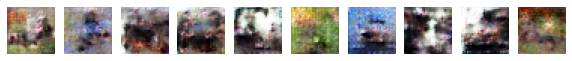

468/468 [==============================] - 205s 435ms/step - d_loss: 0.6455 - g_loss: 0.7901
Epoch 2/50
468/468 [==============================] - 204s 435ms/step - d_loss: 0.5931 - g_loss: 0.8381
Epoch 3/50
468/468 [==============================] - 204s 435ms/step - d_loss: 0.5750 - g_loss: 0.8677
Epoch 4/50
468/468 [==============================] - 209s 446ms/step - d_loss: 0.5699 - g_loss: 0.8737
Epoch 5/50
468/468 [==============================] - 209s 446ms/step - d_loss: 0.5759 - g_loss: 0.8589
Epoch 6/50
468/468 [==============================] - 209s 446ms/step - d_loss: 0.5842 - g_loss: 0.8234
Epoch 7/50
468/468 [==============================] - 209s 446ms/step - d_loss: 0.5805 - g_loss: 0.8233
Epoch 8/50
468/468 [==============================] - 209s 446ms/step - d_loss: 0.5749 - g_loss: 0.8297
Epoch 9/50
468/468 [==============================] - 207s 441ms/step - d_loss: 0.5752 - g_loss: 0.8257
Epoch 10/50
468/468 [==============================] - ETA: 0s - d_loss: 0.

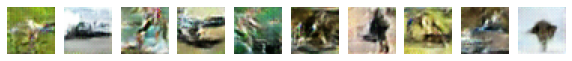

468/468 [==============================] - 207s 443ms/step - d_loss: 0.5715 - g_loss: 0.8245
Epoch 11/50
468/468 [==============================] - 206s 440ms/step - d_loss: 0.5652 - g_loss: 0.8309
Epoch 12/50
468/468 [==============================] - 206s 440ms/step - d_loss: 0.5640 - g_loss: 0.8345
Epoch 13/50
468/468 [==============================] - 206s 441ms/step - d_loss: 0.5583 - g_loss: 0.8301
Epoch 14/50
468/468 [==============================] - 208s 444ms/step - d_loss: 0.5586 - g_loss: 0.8316
Epoch 15/50
468/468 [==============================] - 207s 441ms/step - d_loss: 0.5532 - g_loss: 0.8379
Epoch 16/50
468/468 [==============================] - 207s 442ms/step - d_loss: 0.5498 - g_loss: 0.8410
Epoch 17/50
468/468 [==============================] - 207s 442ms/step - d_loss: 0.5467 - g_loss: 0.8439
Epoch 18/50
468/468 [==============================] - 206s 441ms/step - d_loss: 0.5450 - g_loss: 0.8447
Epoch 19/50
468/468 [==============================] - 207s 441ms/s

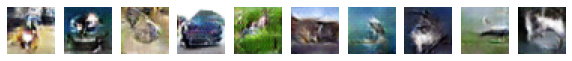

468/468 [==============================] - 207s 443ms/step - d_loss: 0.5383 - g_loss: 0.8441
Epoch 21/50
468/468 [==============================] - 206s 440ms/step - d_loss: 0.5353 - g_loss: 0.8572
Epoch 22/50
468/468 [==============================] - 206s 441ms/step - d_loss: 0.5318 - g_loss: 0.8568
Epoch 23/50
468/468 [==============================] - 206s 441ms/step - d_loss: 0.5284 - g_loss: 0.8577
Epoch 24/50
468/468 [==============================] - 207s 441ms/step - d_loss: 0.5251 - g_loss: 0.8700
Epoch 25/50
468/468 [==============================] - 206s 441ms/step - d_loss: 0.5218 - g_loss: 0.8747
Epoch 26/50
468/468 [==============================] - 206s 441ms/step - d_loss: 0.5199 - g_loss: 0.8697
Epoch 27/50
468/468 [==============================] - 224s 480ms/step - d_loss: 0.5188 - g_loss: 0.8785
Epoch 28/50
468/468 [==============================] - 235s 503ms/step - d_loss: 0.5142 - g_loss: 0.8790
Epoch 29/50
468/468 [==============================] - 236s 505ms/s

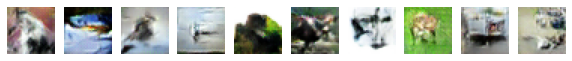

468/468 [==============================] - 235s 503ms/step - d_loss: 0.5137 - g_loss: 0.8794
Epoch 31/50
468/468 [==============================] - 234s 499ms/step - d_loss: 0.5111 - g_loss: 0.8887
Epoch 32/50
468/468 [==============================] - 233s 499ms/step - d_loss: 0.5120 - g_loss: 0.8822
Epoch 33/50
468/468 [==============================] - 228s 487ms/step - d_loss: 0.5090 - g_loss: 0.8848
Epoch 34/50
468/468 [==============================] - 228s 488ms/step - d_loss: 0.5040 - g_loss: 0.8914
Epoch 35/50
468/468 [==============================] - 228s 487ms/step - d_loss: 0.5053 - g_loss: 0.8921
Epoch 36/50
468/468 [==============================] - 202s 431ms/step - d_loss: 0.4988 - g_loss: 0.9004
Epoch 37/50
468/468 [==============================] - 202s 431ms/step - d_loss: 0.4958 - g_loss: 0.9108
Epoch 38/50
468/468 [==============================] - 202s 431ms/step - d_loss: 0.4964 - g_loss: 0.9132
Epoch 39/50
468/468 [==============================] - 202s 431ms/s

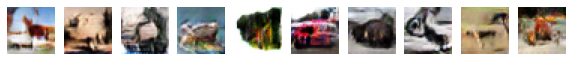

468/468 [==============================] - 202s 433ms/step - d_loss: 0.4904 - g_loss: 0.9237
Epoch 41/50
468/468 [==============================] - 208s 444ms/step - d_loss: 0.4863 - g_loss: 0.9281
Epoch 42/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4808 - g_loss: 0.9517
Epoch 43/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4732 - g_loss: 0.9696
Epoch 44/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4566 - g_loss: 1.0104
Epoch 45/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4468 - g_loss: 1.0348
Epoch 46/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4459 - g_loss: 1.0372
Epoch 47/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4467 - g_loss: 1.0388
Epoch 48/50
468/468 [==============================] - 204s 436ms/step - d_loss: 0.4443 - g_loss: 1.0529
Epoch 49/50
468/468 [==============================] - 205s 437ms/s

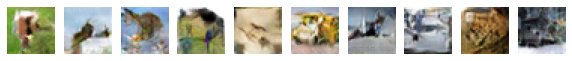

468/468 [==============================] - 205s 438ms/step - d_loss: 0.4408 - g_loss: 1.0580


In [16]:
gan_er = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_er.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan_er.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

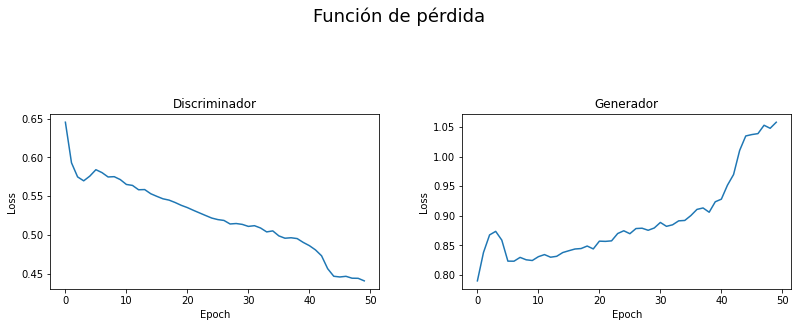

Pérdida discriminador: Min (0.441) Max (0.645) Media (0.523)
Pérdida generador: Min (0.790) Max (1.058) Media (0.891)


In [17]:
plt_loss(history)

#### Resultados
<mark>Tenemos resultados bastante distintos a la anterior prueba. El discriminador, que de por sí ha empezado mejor que en la anterior prueba, ha ido cada vez haciéndose más potente. Podríamos decir, que en este aspecto, el experience replay funciona. Quien no sale tan bien parado es el generador. Si bien ha empezado con una pérdida pareja al discriminador, no ha hecho más que empeorar. Hizo un amago de mejora en la quinta iteración, pero no ha servido de mucho.

Quizás el experience replay potencia demasiado al discriminador, dejando al generador en fuera de juego.</mark>

### GAN condicional
<mark>Las GAN o DCGAN clásicas no nos permiten controlar qué clases van a generar el generador. Para controlar este aspecto, necesitamos una **condición** adicional, como puede ser la clase.

Por tanto, una GAN condicional es una GAN en la cual podemos tener control de qué clases genera el generador. Para cumplir este objetivo, condicionamos el output del GAN con un input semántico.
Las GAN condicionales tienen la capacidad de generar datos condicionadas a una clase en concreto. Ésto tiene ciertas ventajas, como pueden ser lidiar con datasets sin balancear.

Quizás también sirva para obtener mejores métricas en este problema. Vamos a comprobarlo.</mark>

#### Discriminador
<mark>A diferencia que con anteriores discriminadores, aquí tenemos que hacer algunas operaciones más rebuscadas, como puede ser concatenar capas. Para ello, vamos a usar la API funcional de Keras, con la cual tenemos más libertad.

La primera diferencia respecto a GANs no condicionales, es que este discriminador pide dos batches: El de imágenes, y el de etiquetas. Por ello, necesitamos declarar dos capas paralelas, la de input de etiqueta y la de input de imagen. Puesto que necesitamos concatenar ambas para que las capas convulacionales puedan pasarles el filtro, no nos basta con el input sin tratar. Debemos crear una capa densa adicional, con un número de neuronas divisible por las dimensiones de las imágenes. Hacemos reshape, y podemos concatenar sin problemas.

El resto del discriminador es similar a anteriores GANs, solo que ahora las convulaciones obtendrán también la clase aprendida como característica, encriptada en sus mapas de características.</mark>

In [18]:
# INICIO_RESPUESTA
# Requisitos: Implemente el discriminador para la GAN condicional, utilice la estructura del discriminador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «discriminator» para almacenar el discriminador tal y como se hizo en el caso base)
n_classes = 10
input_label = keras.layers.Input(shape=(10,))
#input_label = keras.layers.Embedding(10, 50)(input_label)

dense_label = keras.layers.Dense(32*32*3)(input_label)
dense_label = keras.layers.Reshape((32,32,3))(dense_label)

input_image = keras.layers.Input(shape=(32,32,3))
merge = keras.layers.Concatenate()([input_image,dense_label])

conv = keras.layers.Conv2D(32, kernel_size=[4,4], strides=2, padding="SAME", activation=keras.layers.LeakyReLU())(merge)
conv = keras.layers.BatchNormalization()(conv) # Recomendación del capítulo 17 del libro
conv = keras.layers.Dropout(0.2)(conv)
conv = keras.layers.Conv2D(64, kernel_size=[4,4], strides=2, padding="SAME", activation=keras.layers.LeakyReLU())(conv)
conv = keras.layers.BatchNormalization()(conv) # Recomendación del capítulo 17 del libro
conv = keras.layers.Dropout(0.2)(conv)
conv = keras.layers.Conv2D(128, kernel_size=[4,4], strides=2, padding="SAME", activation=keras.layers.LeakyReLU())(conv)
conv = keras.layers.Flatten()(conv)
output = keras.layers.Dense(1, activation="sigmoid")(conv)

discriminator = keras.Model([input_image,input_label], output)


discriminator.summary()
# FIN_RESPUESTA


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 3072)         33792       ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 32, 32, 3)    0           ['dense_2[0][0]']                
                                                                                              

#### Generador
<mark>Al igual que con el discriminador, con el generador tendremos que aplicar algunos cambios. De forma adicional al input tradicional aleatorio para generar imágenes, concatenaremos un input con diez posibles clases. De igual forma que con el discriminador, aplicaremos también una capa densa y haremos reshape, con un número adecuado para que la concatenación sea posible.

De esta forma, gracias a estas capas densas, el generador tendrá aprendido a genererar un patrón de imágenes dependiendo de la clase dada. Concretamente, las capas convolucionales traspuestas harán el trabajo de leer lo que las capas densas que hemos añadido han aprendido, donde también han aprendido a tratar con las clases.

Por tanto, ahora el generador también pide como input un tensor de etiquetas, de forma adicional al input de GANs anteriores.</mark>

In [19]:
# INICIO_RESPUESTA
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase 
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
input_label = keras.layers.Input(shape=(10,))
input_latent = keras.layers.Input(shape=(100,))

dense_label = keras.layers.Dense(8*8*50)(input_label)
dense_label = keras.layers.Reshape((8,8,50))(dense_label)

dense_latent = keras.layers.Dense(8*8*128)(input_latent)
dense_latent = keras.layers.Reshape((8,8,128))(dense_latent)

merge = keras.layers.Concatenate()([dense_label, dense_latent])

conv = keras.layers.Conv2DTranspose(64, kernel_size=[4,4], strides=2, padding="SAME", activation="relu")(merge)
conv = keras.layers.Conv2DTranspose(64, kernel_size=[4,4], strides=2, padding="SAME", activation="relu")(conv)
output = keras.layers.Conv2D(3, kernel_size=[3,3], strides=1, padding="SAME", activation="tanh")(conv)

generator = keras.Model([input_label, input_latent], output)

generator.summary()
# FIN_RESPUESTA

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 3200)         35200       ['input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 8192)         827392      ['input_5[0][0]']                
                                                                                            

#### Modelo

In [20]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images[0])[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        ee = real_images[1].shape
        xd = random_latent_vectors.shape
        generated_images = self.generator([real_images[1],random_latent_vectors])

        combined_images = tf.concat([generated_images, real_images[0]], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        combined_labels = tf.concat([real_images[1], real_images[1]], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([real_images[1],random_latent_vectors]), real_images[1]])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, y_train_enc = None, num_img=3, latent_dim=100, show_range=10,
                 enable_show=True, enable_save=False,
                 batch_size = 128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save
        self.batch_size = batch_size
        self.y_train_enc = y_train_enc

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          labels = self.y_train_enc[epoch:epoch+self.num_img]
          generated_images = self.model.generator([labels,random_latent_vectors])
          generated_images = (generated_images + 1) / 2.0
          
          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [21]:
# Dado que ahora el generador y el discriminador utilizarán la clase de cada elemento, es necesario utilizar las etiquetas, transformándolas previamente a un array
all_labels_enc = keras.utils.to_categorical(all_labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((all_imgs, all_labels_enc)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

2022-06-12 21:05:38.964455: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 737280000 exceeds 10% of free system memory.


2022-06-12 21:05:39.220269: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/50
468/468 [==============================] - ETA: 0s - d_loss: 0.6941 - g_loss: 0.8105

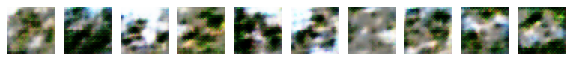

468/468 [==============================] - 187s 398ms/step - d_loss: 0.6941 - g_loss: 0.8105
Epoch 2/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6946 - g_loss: 0.7494
Epoch 3/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6924 - g_loss: 0.7460
Epoch 4/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6922 - g_loss: 0.7454
Epoch 5/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6920 - g_loss: 0.7447
Epoch 6/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 7/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 8/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 9/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 10/50
468/468 [==============================] - ETA: 0s - d_loss: 0.

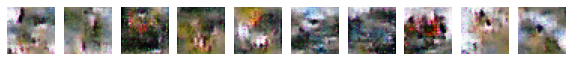

468/468 [==============================] - 185s 396ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 11/50
468/468 [==============================] - 183s 392ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 12/50
468/468 [==============================] - 185s 395ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 13/50
468/468 [==============================] - 189s 404ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 14/50
468/468 [==============================] - 188s 402ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 15/50
468/468 [==============================] - 188s 403ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 16/50
468/468 [==============================] - 189s 404ms/step - d_loss: 0.6919 - g_loss: 0.7447
Epoch 17/50
468/468 [==============================] - 188s 402ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 18/50
468/468 [==============================] - 188s 402ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 19/50
468/468 [==============================] - 188s 402ms/s

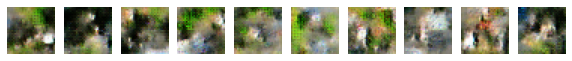

468/468 [==============================] - 196s 418ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 21/50
468/468 [==============================] - 190s 405ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 22/50
468/468 [==============================] - 188s 401ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 23/50
468/468 [==============================] - 188s 401ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 24/50
468/468 [==============================] - 202s 432ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 25/50
468/468 [==============================] - 195s 416ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 26/50
468/468 [==============================] - 194s 415ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 27/50
468/468 [==============================] - 194s 414ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 28/50
468/468 [==============================] - 193s 413ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 29/50
468/468 [==============================] - 193s 412ms/s

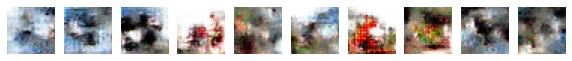

468/468 [==============================] - 194s 414ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 31/50
468/468 [==============================] - 192s 411ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 32/50
468/468 [==============================] - 192s 410ms/step - d_loss: 0.6919 - g_loss: 0.7447
Epoch 33/50
468/468 [==============================] - 194s 414ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 34/50
468/468 [==============================] - 195s 417ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 35/50
468/468 [==============================] - 194s 414ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 36/50
468/468 [==============================] - 195s 416ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 37/50
468/468 [==============================] - 194s 414ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 38/50
468/468 [==============================] - 195s 416ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 39/50
468/468 [==============================] - 193s 412ms/s

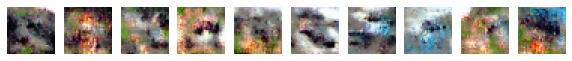

468/468 [==============================] - 194s 414ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 41/50
468/468 [==============================] - 195s 417ms/step - d_loss: 0.6919 - g_loss: 0.7443
Epoch 42/50
468/468 [==============================] - 196s 418ms/step - d_loss: 0.6919 - g_loss: 0.7446
Epoch 43/50
468/468 [==============================] - 196s 420ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 44/50
468/468 [==============================] - 196s 419ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 45/50
468/468 [==============================] - 196s 418ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 46/50
468/468 [==============================] - 196s 419ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 47/50
468/468 [==============================] - 196s 419ms/step - d_loss: 0.6919 - g_loss: 0.7445
Epoch 48/50
468/468 [==============================] - 195s 417ms/step - d_loss: 0.6919 - g_loss: 0.7444
Epoch 49/50
468/468 [==============================] - 195s 417ms/s

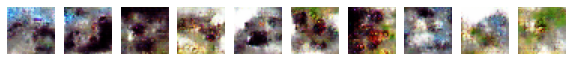

468/468 [==============================] - 195s 416ms/step - d_loss: 0.6919 - g_loss: 0.7445


In [22]:
conditional_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
conditional_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn
)

history = conditional_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(all_labels_enc,
                                                                num_img=10,
                                                                latent_dim=latent_dim)])

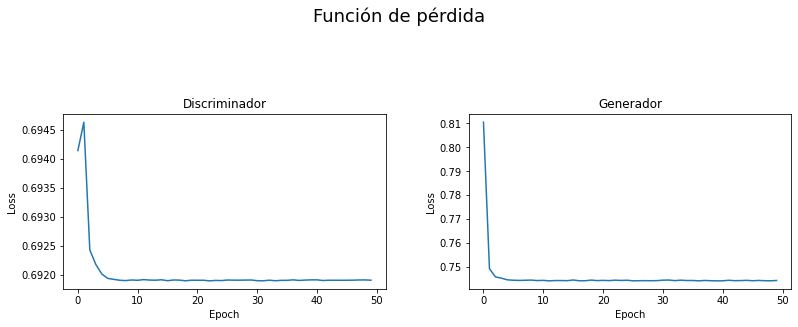

Pérdida discriminador: Min (0.692) Max (0.695) Media (0.692)
Pérdida generador: Min (0.744) Max (0.810) Media (0.746)


In [23]:
plt_loss(history)

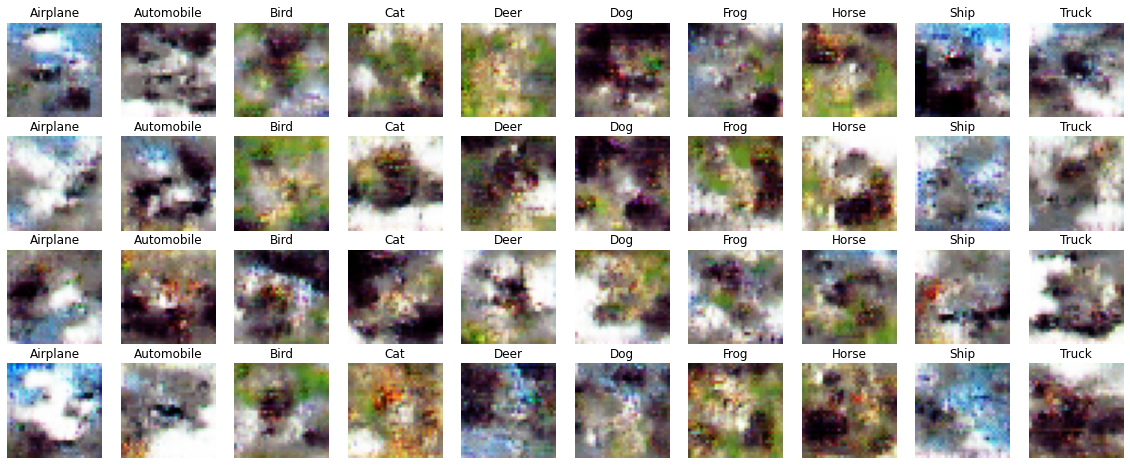

In [24]:
classes_labels = keras.utils.to_categorical([x for x in range(10)] * 4, 10)

random_latent_vectors = tf.random.normal(shape=(len(classes_labels), latent_dim))
generated_images = conditional_gan.generator([classes_labels,random_latent_vectors])
generated_images = (generated_images + 1) / 2.0
# generated_images.numpy()
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
pos = 1
classes_to_int = np.argmax(classes_labels, axis=-1)
for n in range(generated_images.shape[0]):
    plt.subplot(4, 10, pos)
    img = keras.preprocessing.image.array_to_img(generated_images[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(clases[classes_to_int[n]], size=12)
    pos += 1
plt.show()

#### Resultados
<mark>En principio no vemos grandes diferencias respecto a la GAN original. Quizás porque las GANs condicionales brillan en casos más concretos, como datasets poco balanceados. En cualquier caso, ha merecido la pena el intento, no sólo por aprender una arquitectura diferente sino también por aprender a usar la API funcional de Keras.

A pesar de que aparentemente no se aprecia nada en las imáganes, si nos fijamos detalladamente, sí que vemos cosas con sentido. Vemos que tanto en aviones como en barcos hay mucho azul, podría corresponder con cielo y mar, respectivamente. También vemos que con animales tiende más el verde (césped u hojas?) y con coche y camión hay algo de gris, que podría ser carretera.

Mi opinión personal es que falta profindidad en los generadores y discriminadores, la red no es suficientemente profunda como para aprender características tan complejas.</mark>

### Conclusiones finales
<mark>Como resumen del trabajo, podemos decir que hemos intentado afrontar el problema con distintas técnicas. Hemos usado DCGANs clásicas, hemos usado técnicas como el experience replay para intentar solventar algunos vicios de la primera, y hemos probado alternativas como las GAN condicionales. Si bien los resultados no son demasiado buenos, no dispongo del hardware necesario para hacer todas las pruebas que me gustaría. El entrenamiento dura varias horas, por lo que no tengo mucho margen de mejora.

Las GANs son muy abiertas a posibilidades, y las combinaciones de parámetros y cambios que podemos añadir son infinitas. Quizás con un equipo potente y el suficiente tiempo podría haber encontrado una combinación que funcione mejor.

Como conclusión personal podría decir que esta práctica ha sido algo dura, pero por culpa mía. La primera vez que me enfrenté a ella, lo hice habiéndome leído los apuntes por encima, y no tenía muy claro qué hacían las capas convolucionales, densas, reshape, los canales... Entendía el concepto muy por encima. Lógicamente, me quedé en el experience replay. En mi segundo intento, habíendome leído los apuntes mejor, conseguí hacer hasta la GAN condicional, donde debíamos usar la API funcional. No ha sido hasta al hacer el examen, donde tenía todos los conceptos totalmente asumidos, cuando he conseguido terminar la práctica completamente.

En conclusión el trabajo me parece muy didáctico, si bien hay guías en internet, no sirven de nada si no entiendes bien los conceptos, pues hay que añadir variaciones que sólo si tienes el conocimiento adecuado puedes añadir. Por tanto, estoy satisfecho.</mark>

### (Opcional) Cycle-GANs 
<mark>"Cycle-GANs" es una forma abreviada de "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks".

El objetivo de las Cycle-GANs es aprender el mapeado entre una imagen de input y una imagen de output usando un set de pares de imágenes. Puesto que muchas veces estos pares de imágenes no están disponibles, se presenta un modelo que puede "traducir" imágenes a su versión pareja a partir de un entrenamiento con otros ejemplos. Ejemplos de esta transición pueden ser cambiar un paisaje de estación, día y noche, o el color de los edificios.

Respecto a los métodos ya vistos, hay bastantes novedades y diferencias. La primera es que se incluyen dos discriminadores, y no uno: Un discriminador para distinguir entre imágenes, y otro para distinguir entre imágenes "traducidas". Otra gran novedad es que no se busca una nueva imagen, creada de cero. Lo que se busca es una "traducción", un cambio en la imágen original, como puede ser, cambiar el color del cielo, u otros ejemplos anteriormente descritos. Por último, queda señalar la proveniencia del nombre. El modelo de los Cycle-GANs contienen dos funciones de mapping: una de X -> Y y otra de Y -> X, los cuales están asociados a los discriminadores antes descritos. De forma que el primer discriminador intenta traducir la imagen original a la traducida, y viceversa para el segundo.

Para regularizar estos mapeados, se introducen dos medidas de pérdida de consistencia de ciclo, que capturan la intuición de que si traducimos y volvemos a traducir a la inversa, obtenemos la misma imagen de origen. Es por ello que se habla de ciclos en el nombre. La explicación completa se puede encontrar en el siguiente paper:https://arxiv.org/pdf/1703.10593.pdf </mark>